In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vivek6352","key":"f81542d6d2b744a0beedfc04737c59a0"}'}

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:02<00:00, 287MB/s]
100% 812M/812M [00:03<00:00, 281MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

**1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**

We are initially taking the train sample of 1000 by taking first 1000 values in the dataset. Taking 500 validation samples starting from 1000 to 1500 values in the dataset, taking 500 test samples starting from 1500 to 2000 values in the dataset.

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Here we are preprocessing the data

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Importing the numpy as np and creating the dataset with 1000 samples with vector 16.

In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


Here we are taking 32 as batch size for the data

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


Reshaping the dataset using dataset.map

In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Using Keras with convolutions and Maxpooling: Creates convolutions kernel that is convolved with the layer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
a = layers.Rescaling(1./255)(inputs)
a = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.Flatten()(a)
a = layers.Dropout(0.5)(a)
outputs = layers.Dense(1, activation="sigmoid")(a)
model = keras.Model(inputs=inputs, outputs=outputs)

Configuring the model for training using biary crossentropy as loss function, adam optimizer and accuracy to measure the performance of the model.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

A record of the training measurements and loss values at different epochs, along with validation metrics and loss values, is called a history attribute.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 17s 135ms/step - loss: 0.6955 - accuracy: 0.5140 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6841 - accuracy: 0.5640 - val_loss: 0.6762 - val_accuracy: 0.5610
Epoch 3/50
63/63 [==============================] - 4s 59ms/step - loss: 0.6632 - accuracy: 0.6020 - val_loss: 0.6161 - val_accuracy: 0.6530
Epoch 4/50
63/63 [==============================] - 6s 99ms/step - loss: 0.6212 - accuracy: 0.6450 - val_loss: 0.6224 - val_accuracy: 0.6600
Epoch 5/50
63/63 [==============================] - 4s 62ms/step - loss: 0.6042 - accuracy: 0.6825 - val_loss: 0.5853 - val_accuracy: 0.6840
Epoch 6/50
63/63 [==============================] - 5s 83ms/step - loss: 0.5438 - accuracy: 0.7335 - val_loss: 0.5682 - val_accuracy: 0.6950
Epoch 7/50
63/63 [==============================] - 6s 87ms/step - loss: 0.4911 - accuracy: 0.7550 - val_loss: 0.5500 - val_accuracy: 0.7300
Epoch 8/50


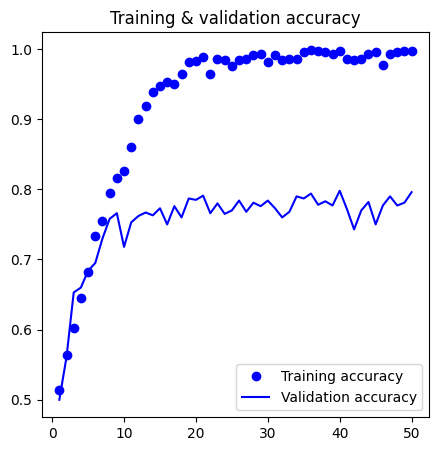

<Figure size 640x480 with 0 Axes>

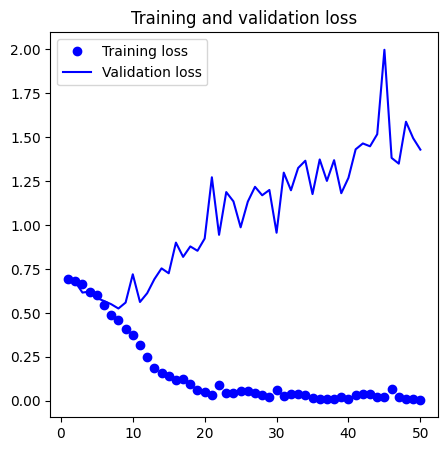

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.5921 - accuracy: 0.7190
Test accuracy: 0.719


**2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

Here we are incresing the train sample size to 1500 by taking the values from 2000 to 3500 and keeping the validation and test values constant i.e., 500.

In [ ]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=2000, end_index=3500)
make_subset("validation", start_index=3501, end_index=4001)
make_subset("test", start_index=4002, end_index=4502)

Here we are using the data augmentation technique to optimize the model performance as we are dealing with large datasets (increased the train sample size to 1500)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Display of few sample images in the dataset.

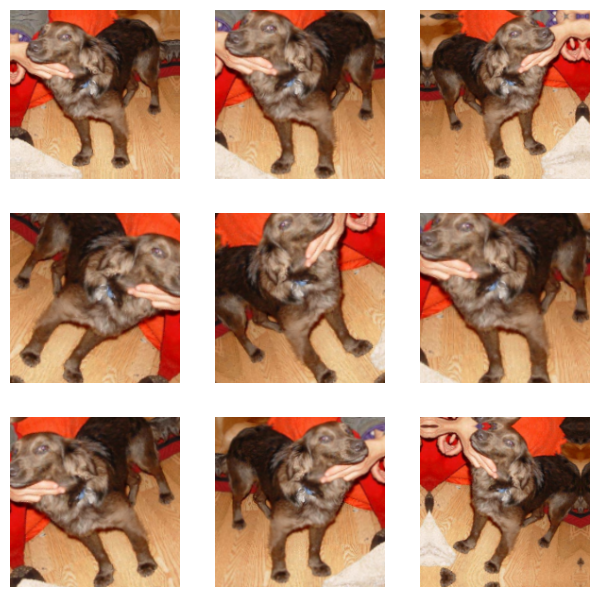

In [ ]:
plt.figure(figsize=(7.5,7.5 ))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Using Data Augmentation and Dropout to optimize the model. Dropout layer only applies when training is set to True such that no values are dropped during inference

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 67ms/step - loss: 0.6974 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6936 - accuracy: 0.5080 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 6s 90ms/step - loss: 0.6891 - accuracy: 0.5335 - val_loss: 0.6611 - val_accuracy: 0.6280
Epoch 4/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6659 - accuracy: 0.6135 - val_loss: 0.6510 - val_accuracy: 0.6180
Epoch 5/100
63/63 [==============================] - 4s 60ms/step - loss: 0.6464 - accuracy: 0.6305 - val_loss: 0.6435 - val_accuracy: 0.6320
Epoch 6/100
63/63 [==============================] - 7s 105ms/step - loss: 0.6534 - accuracy: 0.6295 - val_loss: 0.6437 - val_accuracy: 0.6280
Epoch 7/100
63/63 [==============================] - 4s 61ms/step - loss: 0.6325 - accuracy: 0.6365 - val_loss: 0.6936 - val_accuracy: 0.6230
Epoch

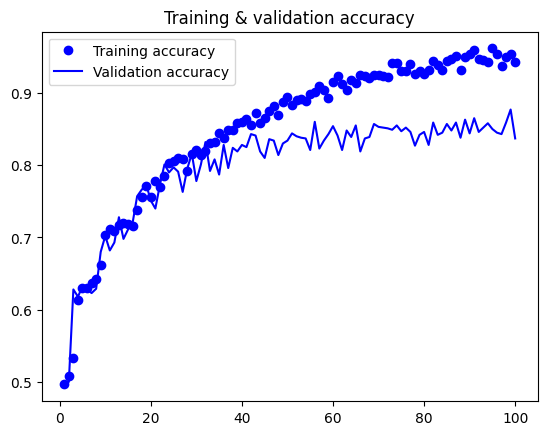

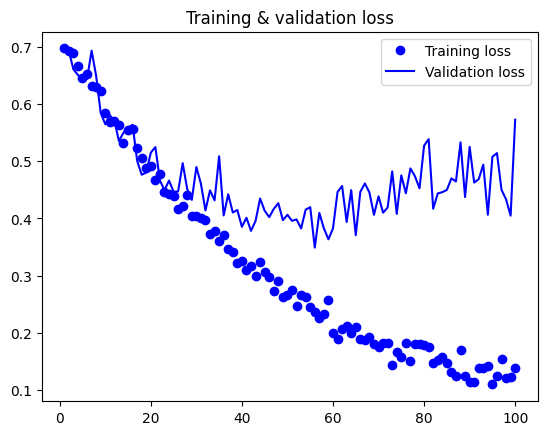

In [ ]:

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 27ms/step - loss: 0.4353 - accuracy: 0.8400
Test accuracy: 0.840


**3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**

Increasing the training sample size to 2000 taking the values from 4000 to 6000 from dataset and keeping the validation and test and validation sample sizes to 500 only.

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=4000, end_index=6000)
make_subset("validation", start_index=6001, end_index=6501)
make_subset("test", start_index=6502, end_index=7002)

A new convent:

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=75,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/75
63/63 [==============================] - 9s 90ms/step - loss: 0.6970 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/75
63/63 [==============================] - 4s 60ms/step - loss: 0.6932 - accuracy: 0.5225 - val_loss: 0.6890 - val_accuracy: 0.5100
Epoch 3/75
63/63 [==============================] - 4s 60ms/step - loss: 0.6874 - accuracy: 0.5450 - val_loss: 0.6932 - val_accuracy: 0.5130
Epoch 4/75
63/63 [==============================] - 7s 106ms/step - loss: 0.6756 - accuracy: 0.5685 - val_loss: 0.6505 - val_accuracy: 0.6010
Epoch 5/75
63/63 [==============================] - 4s 60ms/step - loss: 0.6899 - accuracy: 0.5255 - val_loss: 0.6891 - val_accuracy: 0.5300
Epoch 6/75
63/63 [==============================] - 4s 62ms/step - loss: 0.6620 - accuracy: 0.6000 - val_loss: 0.6533 - val_accuracy: 0.6060
Epoch 7/75
63/63 [==============================] - 6s 93ms/step - loss: 0.6529 - accuracy: 0.6240 - val_loss: 0.6895 - val_accuracy: 0.5400
Epoch 8/75
6

Graph of training and validation accuracy

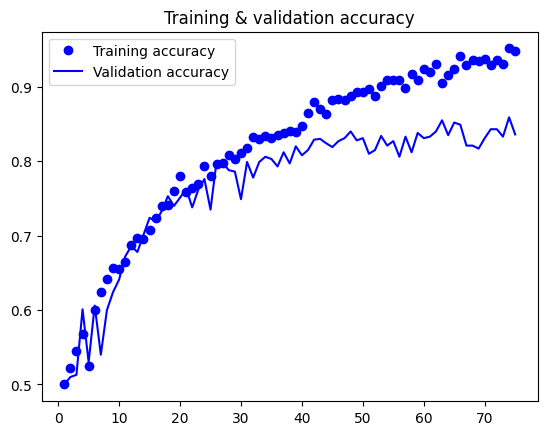

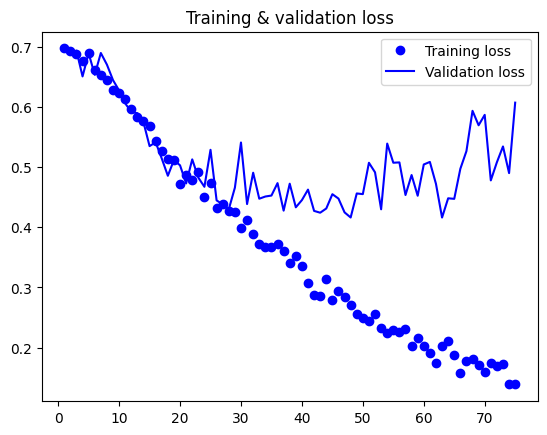

In [ ]:

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.4473 - accuracy: 0.8330
Test accuracy: 0.833


In the beginning as we took only 1000 samples in the first question and we acheived an accuracy of 74% but the same when we saw above with increasing the sample size to double we received 83% accuracy, the problem was overfitting and hence we generalized the model. As there was overfitting we used techniques like data augmentation and dropout to generalize the model.

**4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**

Using pretrained model with Feature extraction technique

Using the VGG16 convolutional base which describes the first several layers of the the architecture, which are in charge of taking hierarchical features out of input images.

In [ ]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Feature extraction without data augmentation using a pretrained model




In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 19ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=40,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/40
63/63 [==============================] - 1s 10ms/step - loss: 13.8645 - accuracy: 0.9285 - val_loss: 7.9692 - val_accuracy: 0.9530
Epoch 2/40
63/63 [==============================] - 1s 8ms/step - loss: 3.3413 - accuracy: 0.9805 - val_loss: 7.0261 - val_accuracy: 0.9640
Epoch 3/40
63/63 [==============================] - 1s 8ms/step - loss: 3.1077 - accuracy: 0.9790 - val_loss: 5.3317 - val_accuracy: 0.9650
Epoch 4/40
63/63 [==============================] - 0s 6ms/step - loss: 0.5525 - accuracy: 0.9945 - val_loss: 7.7337 - val_accuracy: 0.9670
Epoch 5/40
63/63 [==============================] - 1s 8ms/step - loss: 1.6439 - accuracy: 0.9930 - val_loss: 2.8640 - val_accuracy: 0.9790
Epoch 6/40
63/63 [==============================] - 0s 6ms/step - loss: 0.5152 - accuracy: 0.9945 - val_loss: 4.1415 - val_accuracy: 0.9770
Epoch 7/40
63/63 [==============================] - 0s 5ms/step - loss: 0.4014 - accuracy: 0.9935 - val_loss: 5.4313 - val_accuracy: 0.9740
Epoch 8/40
63/63 [

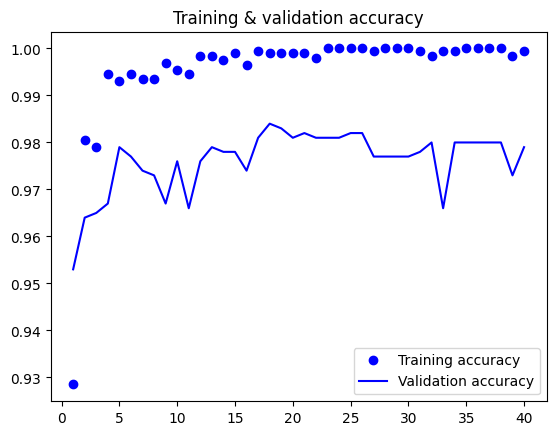

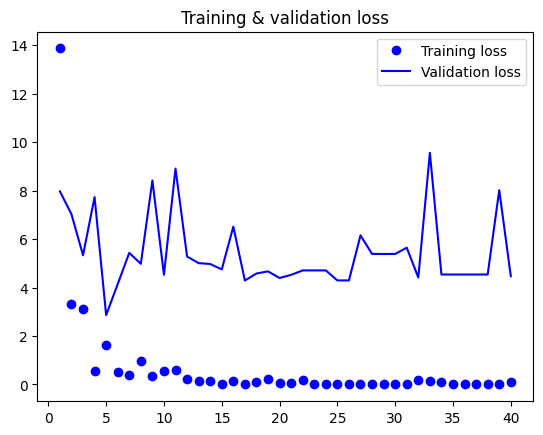

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

Freezing the VGG16 convolutional base as in feature extraction we freeze the initial trained base

In [ ]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

In [ ]:
convolution_base.trainable = True
print("The number of trainable weights required to use the convolution base before it freezes is as follows:", len(convolution_base.trainable_weights))

The number of trainable weights required to use the convolution base before it freezes is as follows: 26


In [ ]:
convolution_base.trainable = False
print("After the convolution base is frozen, this is the total quantity of trainable weights:", len(convolution_base.trainable_weights))

After the convolution base is frozen, this is the total quantity of trainable weights: 0


Adding data augmentation:

In [ ]:
augmentation2 = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=75,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/75
63/63 [==============================] - 11s 158ms/step - loss: 21.3565 - accuracy: 0.8905 - val_loss: 3.6533 - val_accuracy: 0.9780
Epoch 2/75
63/63 [==============================] - 11s 176ms/step - loss: 5.8368 - accuracy: 0.9555 - val_loss: 14.6469 - val_accuracy: 0.9350
Epoch 3/75
63/63 [==============================] - 11s 177ms/step - loss: 6.2118 - accuracy: 0.9540 - val_loss: 4.1224 - val_accuracy: 0.9740
Epoch 4/75
63/63 [==============================] - 9s 141ms/step - loss: 5.8927 - accuracy: 0.9610 - val_loss: 5.8974 - val_accuracy: 0.9710
Epoch 5/75
63/63 [==============================] - 11s 174ms/step - loss: 3.6089 - accuracy: 0.9675 - val_loss: 3.9631 - val_accuracy: 0.9780
Epoch 6/75
63/63 [==============================] - 10s 148ms/step - loss: 3.3797 - accuracy: 0.9715 - val_loss: 5.0010 - val_accuracy: 0.9710
Epoch 7/75
63/63 [==============================] - 9s 141ms/step - loss: 3.3175 - accuracy: 0.9740 - val_loss: 4.7262 - val_accuracy: 0.9720

In [ ]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras",safe_mode=False)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 88ms/step - loss: 2.1661 - accuracy: 0.9790
Test accuracy: 0.979


A pretrained VGG16 model with Fine-tuning

Fine-tuning the pretrained model which already discovered some useful characteristics from a large set of data, speed-to-convergence is accelerated as compared to training from scratch. The model may overfit the dataset that the model is tuned on if it is not fine-tunned on a new dataset. This may result in it meshing its learned features better to the features of this new dataset leading to improved generalization performance.

In [ ]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 178ms/step - loss: 0.3884 - accuracy: 0.9920 - val_loss: 1.7505 - val_accuracy: 0.9780
Epoch 2/50
63/63 [==============================] - 11s 170ms/step - loss: 0.4428 - accuracy: 0.9915 - val_loss: 1.5815 - val_accuracy: 0.9810
Epoch 3/50
63/63 [==============================] - 11s 166ms/step - loss: 0.2220 - accuracy: 0.9940 - val_loss: 1.6590 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 12s 192ms/step - loss: 0.0601 - accuracy: 0.9970 - val_loss: 1.5932 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 10s 161ms/step - loss: 0.0859 - accuracy: 0.9950 - val_loss: 2.6349 - val_accuracy: 0.9750
Epoch 6/50
63/63 [==============================] - 10s 154ms/step - loss: 0.2347 - accuracy: 0.9905 - val_loss: 2.1413 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 10s 163ms/step - loss: 0.2364 - accuracy: 0.9930 - val_loss: 1.7220 - val_accuracy: 0.9780

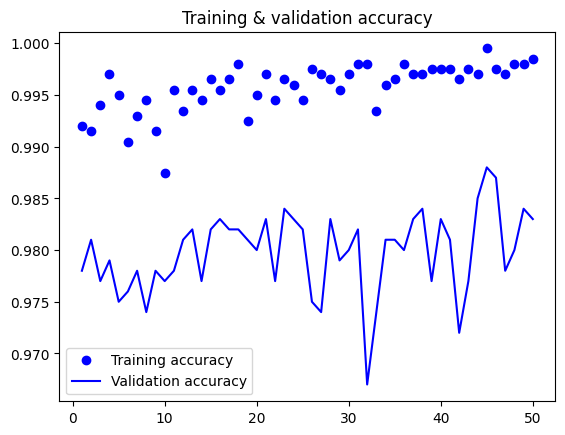

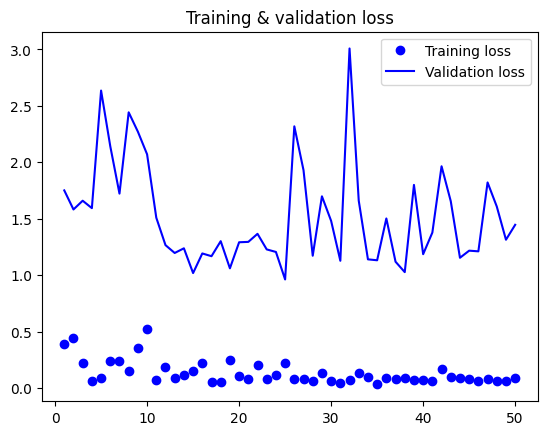

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 87ms/step - loss: 2.2782 - accuracy: 0.9740
Test accuracy: 0.974
